In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
#import librosa
#import utils
#import ast
import pickle
#import fma_utils
#import kapre
#from kapre.time_frequency import Spectrogram, Melspectrogram
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_io as tfio


#import os
#import shutil
#from IPython.display import display, Audio


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUDIO_DIR = 'data/fma_small'
SR = 16000
BATCH_SIZE = 8
#INP_SHAPE = (1190700, 2)
INP_SHAPE = (160000, 2)
MFCC_SHAPE = (BATCH_SIZE, 160000, 128)
START = 441000 
END = 882000

In [4]:
#load 
fma_multi = pickle.load(open("saved/fma_multi.p", "rb"))

In [5]:
fma_multi.head()

,split,subset,filepath,genres_all,genre_top
track_id,,,,,
2,training,small,data/fma_large/000/000002.mp3,[21],Hip-Hop
3,training,medium,data/fma_large/000/000003.mp3,[21],Hip-Hop
5,training,small,data/fma_large/000/000005.mp3,[21],Hip-Hop
10,training,small,data/fma_large/000/000010.mp3,[10],Pop
20,training,large,data/fma_large/000/000020.mp3,"[17, 10, 76, 103]",NaN


In [6]:
#use the 8000 track balanced subset for baseline modeling
subset = fma_multi.index[fma_multi['subset'] == 'small']

In [7]:
fma_small = fma_multi.loc[subset]

In [8]:
fma_small['filepath'] = fma_small['filepath'].str.replace('large','small')

In [9]:
fma_small

,split,subset,filepath,genres_all,genre_top
track_id,,,,,
2,training,small,data/fma_small/000/000002.mp3,[21],Hip-Hop
5,training,small,data/fma_small/000/000005.mp3,[21],Hip-Hop
10,training,small,data/fma_small/000/000010.mp3,[10],Pop
140,training,small,data/fma_small/000/000140.mp3,[17],Folk
141,training,small,data/fma_small/000/000141.mp3,[17],Folk
...,...,...,...,...,...
154308,test,small,data/fma_small/154/154308.mp3,"[811, 539, 21]",Hip-Hop
154309,test,small,data/fma_small/154/154309.mp3,"[811, 539, 21]",Hip-Hop
154413,training,small,data/fma_small/154/154413.mp3,"[10, 76]",Pop


In [10]:
drop3=pickle.load(open("saved/drop3.p","rb"))

In [11]:
fma_small.drop(drop3, inplace=True)

In [12]:
#use the built in train/test/validation split in case we want to compare to other models over this dataset
train = fma_small.index[fma_small['split'] == 'training']
val = fma_small.index[fma_small['split'] == 'validation']
test = fma_small.index[fma_small['split'] == 'test']

In [13]:
print('training set size: ', len(train))
print('validation set size: ', len(val))
print('test set size: ', len(test))

training set size:  6310
validation set size:  793
test set size:  794


In [14]:
enc = LabelEncoder()

X_train = fma_small['filepath'].loc[train]
X_val = fma_small['filepath'].loc[val]
X_test = fma_small['filepath'].loc[test]
y_train = enc.fit_transform(fma_small['genre_top'].loc[train])
y_val = enc.transform(fma_small['genre_top'].loc[val])
y_test = enc.transform(fma_small['genre_top'].loc[test])

In [15]:
def parse_audio_mfcc(filename,  label):
    """returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
   
    audio = audio[START:END] #crop to uniform size
    audio = tfio.audio.resample(audio, 44100, 16000)
    spectrogram = tfio.experimental.audio.spectrogram(audio, nfft=512, window=512, stride=256)
    mel_spectrogram = tfio.experimental.audio.melscale(spectrogram, rate=SR, mels=128, fmin=0, fmax=8000)
    dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(mel_spectrogram, top_db=80)
    mfcc=tf.signal.mfccs_from_log_mel_spectrograms(dbscale_mel_spectrogram)
    mfcc=tf.squeeze(mfcc)
    return mfcc, label

In [16]:
def parse_audio(filename,  label):
    """returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)   
      
    audio = audio[START:END] #crop to uniform size
    
    #resample to reduse data size, we don't need 44.1kHz fidelity, 16k will be plenty
    audio = tfio.audio.resample(audio, 44100, SR)
    return audio, label

In [17]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [18]:
#data pipeline
def get_data(dataset):
    dataset = dataset.shuffle(buffer_size=len(train), seed=42)
    dataset = dataset.map(parse_audio, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [19]:
#data pipeline
def get_mfcc_data(dataset):
    dataset = dataset.shuffle(buffer_size=len(train), seed=42)
    dataset = dataset.map(parse_audio_mfcc, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [20]:
train_ds = get_data(train_ds)
val_ds = get_data(val_ds)
test_ds = get_data(test_ds)

In [21]:
#define model
#basic CNN architecture from TF documentation
keras.backend.clear_session()
model = models.Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, input_shape=INP_SHAPE))

model.add(layers.Conv1D(32, 3, activation='relu'))

model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.MaxPooling1D(4))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(.25))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 160000, 2)         5         
_________________________________________________________________
conv1d (Conv1D)              (None, 159998, 32)        224       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 79999, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 79998, 64)         4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19999, 64)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19997, 32)         6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6665, 32)          0

In [22]:
history = model.fit(train_ds, 
                    epochs=10,                    
                    validation_data=val_ds)

Epoch 1/10
789/789 [==============================] - 109s 138ms/step - loss: 2.0842 - accuracy: 0.1334 - val_loss: 2.0800 - val_accuracy: 0.1198
Epoch 2/10
789/789 [==============================] - 112s 142ms/step - loss: 2.0790 - accuracy: 0.1276 - val_loss: 2.0758 - val_accuracy: 0.1274
Epoch 3/10
789/789 [==============================] - 113s 143ms/step - loss: 2.0804 - accuracy: 0.1217 - val_loss: 2.0795 - val_accuracy: 0.1261
Epoch 4/10
789/789 [==============================] - 113s 143ms/step - loss: 2.0799 - accuracy: 0.1174 - val_loss: 2.0795 - val_accuracy: 0.1261
Epoch 5/10
789/789 [==============================] - 116s 147ms/step - loss: 2.0799 - accuracy: 0.1198 - val_loss: 2.0794 - val_accuracy: 0.1261
Epoch 6/10
789/789 [==============================] - 116s 147ms/step - loss: 2.0823 - accuracy: 0.1204 - val_loss: 2.0795 - val_accuracy: 0.1261
Epoch 7/10
789/789 [==============================] - 116s 147ms/step - loss: 2.0799 - accuracy: 0.1197 - val_loss: 2.0795 -

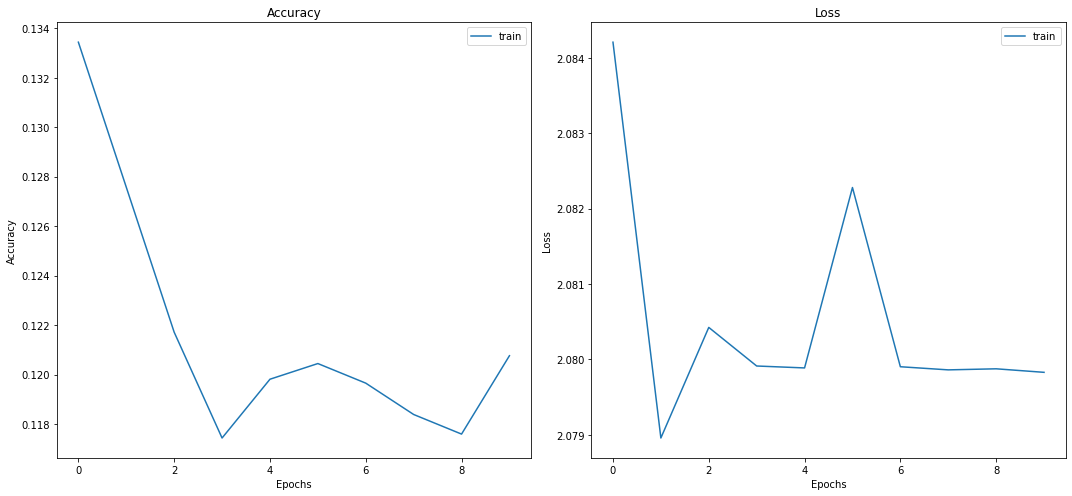

In [23]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#make clear this is test set
y_pred=model.predict_classes(X_test)
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_pred=np.argmax(model.predict(X_test) > 0.5).astype("int32"))
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))